In [13]:
import pickle as plk
import os
import argparse
import torch
import transformers 
import os
from tqdm import tqdm
import numpy as np

from model_lib.hf_tooling import HF_Llama2_Wrapper
from model_lib.attention_tools import run_attention_monitor
from factual_queries import load_constraint_dataset
from viz_tools import plot_attention_flow
import torch
import numpy as np
from tqdm import tqdm
from easydict import EasyDict as edict

from model_lib.hooks import TraceDict
from model_lib.misc_utils import repeat_kv, find_within_text
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [14]:
def find_all_phrase_indexes(tokens, phrase):
    """
    Find all start and end indexes of a given phrase in a list of tokens.

    :param tokens: List of tokens.
    :param phrase: The phrase to find within the list of tokens.
    :return: A list of tuples containing the start and end indexes of each occurrence of the phrase.
    """
    # Remove spaces in the phrase
    # phrase_no_spaces = phrase.replace(' ', '')
    phrase_len = len(phrase)
    matches = []
    
    for i in range(len(tokens)):
        concatenated = ''
        for j in range(i, len(tokens)):
            concatenated += tokens[j]
            if concatenated == phrase:
                matches.append((i, j))
                break
            elif len(concatenated) > phrase_len:
                break
    
    if len(matches) ==0:
        phrase = phrase.replace(' ', '')
        phrase_len = len(phrase)
        matches = []
        
        for i in range(len(tokens)):
            concatenated = ''
            for j in range(i, len(tokens)):
                concatenated += tokens[j]
                if concatenated == phrase:
                    matches.append((i, j))
                    break
                elif len(concatenated) > phrase_len:
                    break

    
    return matches

# Get Prediction indexes
#### Returns [Correct, Semi Correct, Incorrect] Indices

In [15]:
def getPredictionCategories(directory):
    # Get the list of all file names in the specified directory
    file_names = os.listdir(os.path.join('run-rag-synthetic-counterfact-position-0', 'data'))

    # Initialize sets to categorize predictions
    first_token_prediction = set()
    present_in_generation = set()
    incorrect = set()

    # Loop through each file in the directory
    for file in file_names:
        # Load the data from the current file
        with open(os.path.join(directory, 'data', file), 'rb') as f:
            data = plk.load(f)
        
        # Extract the correct answer from the constraints
        answer = data['constraints'][0].strip()
        
        # Categorize the prediction based on the completion
        if data['completion'].strip().startswith(answer):
            # If the completion starts with the correct answer, add to first_token_prediction
            first_token_prediction.add(int(data['id']))
        elif answer in data['completion']:
            # If the correct answer is present anywhere in the completion, add to present_in_generation
            present_in_generation.add(int(data['id']))
        else:
            # If the correct answer is not present in the completion, add to incorrect
            incorrect.add(int(data['id']))
    
    # Return the sets of categorized predictions
    return first_token_prediction, present_in_generation, incorrect


# Histogram across contribution values

In [16]:
def get_subject_contribution_bucket(directory, indexes = None):
    count = 0
    def get_query_subject_index(token_labels, constraint):
        try:
            return find_all_phrase_indexes(token_labels, constraint.strip())[-1]
        except IndexError:
            return find_all_phrase_indexes(token_labels, constraint)[-1]

    file_names = os.listdir(os.path.join('run-rag-synthetic-counterfact-position-0', 'data'))
    subject_contribution_bucket = []
    for name in file_names:
        with open(os.path.join(directory, 'data', name), 'rb') as f:
            data = plk.load(f)
        if indexes:
            if int(data['id']) not in indexes:
                continue
        try:
    # Attempt to get the query subject index
            query_subject_index = get_query_subject_index(data['token_labels'], data['constraints'][-1])
            
            # Calculate flow_info using the obtained index
            flow_info = data['all_token_contrib_norms'].T[query_subject_index[0]:query_subject_index[1] + 1]
            subject_contribution_bucket.extend(flow_info.flatten())
            count+=1
            
        except Exception as e:
            print(f"Exception encountered: {e}")
            print("Error occurred for data id:", data["id"])
    print(count)
    return np.array(subject_contribution_bucket)

def filter_top_percentile(data, percentile=95):
    threshold = np.percentile(data, percentile)
    return data[data >= threshold]



In [17]:
def get_attribute_contribution_bucket(directory, indexes = None):
    def get_query_subject_index(token_labels, constraint):
        try:
            return find_all_phrase_indexes(token_labels, constraint.strip())[-1]
        except IndexError:
            return find_all_phrase_indexes(token_labels, constraint)[-1]
    file_names = os.listdir(os.path.join('run-rag-synthetic-counterfact-position-0', 'data'))
    subject_contribution_bucket = []
    for name in file_names:
        with open(os.path.join(directory, 'data', name), 'rb') as f:
            data = plk.load(f)
        if indexes:
            if int(data['id']) not in indexes:
                continue
        try:
    # Attempt to get the query subject index
            query_subject_index = get_query_subject_index(data['token_labels'], data['constraints'][0])
            
            # Calculate flow_info using the obtained index
            flow_info = data['all_token_contrib_norms'].T[query_subject_index[0]:query_subject_index[1] + 1]
            subject_contribution_bucket.extend(flow_info.flatten())
            
        except Exception as e:
            print(f"Exception encountered: {e}")
            print("Error occurred for data id:", data["id"])
    
    return np.array(subject_contribution_bucket)



In [18]:
#Contribution = Both compares attention and subject within one directory. i.e subject vs attribute for llama-2 rag at position 0.
def compare_top_values_histograms(directories, percentile=95, contribution="both", indexes=None):
    data_list = []

    if contribution == 'both' and len(directories) != 1:
        raise ValueError("When contribution is 'both', only one directory should be provided.")
    
    for directory in directories:
        if contribution in ['attribute', 'both']:
            attribute_data = get_attribute_contribution_bucket(directory, indexes)
            attribute_data_top = filter_top_percentile(attribute_data, percentile)
            data_list.append(pd.DataFrame({
                'Attention Contribution': attribute_data_top,
                'Dataset': f'{directory} (Attribute)',
                'Contribution': 'Attribute'
            }))

        if contribution in ['subject', 'both']:
            subject_data = get_subject_contribution_bucket(directory, indexes)
            subject_data_top = filter_top_percentile(subject_data, percentile)
            data_list.append(pd.DataFrame({
                'Attention Contribution': subject_data_top,
                'Dataset': f'{directory} (Subject)',
                'Contribution': 'Subject'
            }))
    
    # Combine all data into a single DataFrame
    combined_data = pd.concat(data_list, ignore_index=True)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.histplot(data=combined_data, x='Attention Contribution', hue='Dataset', element='step', stat='density', common_norm=False)
    plt.title(f'Comparison of Top {100 - percentile}% Attention Contributions - Histogram')
    plt.xlabel('Attention Contribution Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

    # Box Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=combined_data, x='Dataset', y='Attention Contribution')
    plt.title(f'Comparison of Top {100 - percentile}% Attention Contributions - Box Plot')
    plt.grid(True)
    plt.show()

Exception encountered: list index out of range
Error occurred for data id: 258
Exception encountered: list index out of range
Error occurred for data id: 573
Exception encountered: list index out of range
Error occurred for data id: 606
977


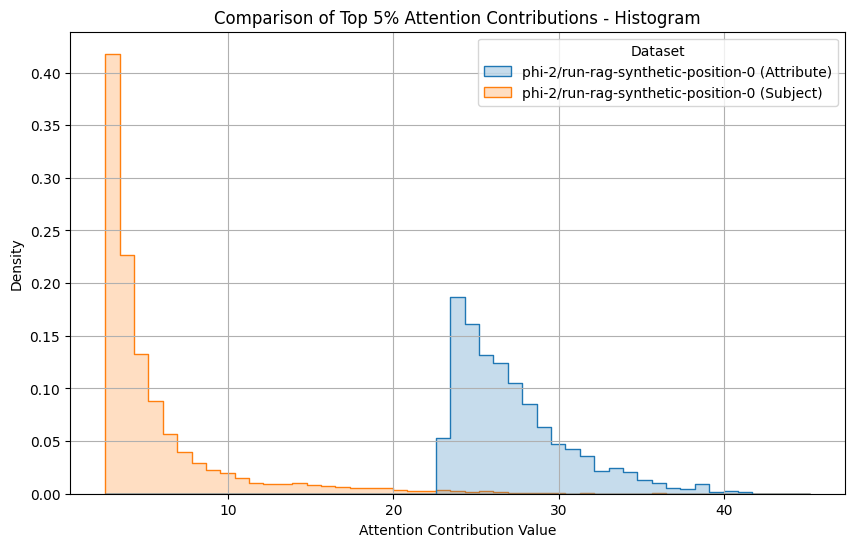

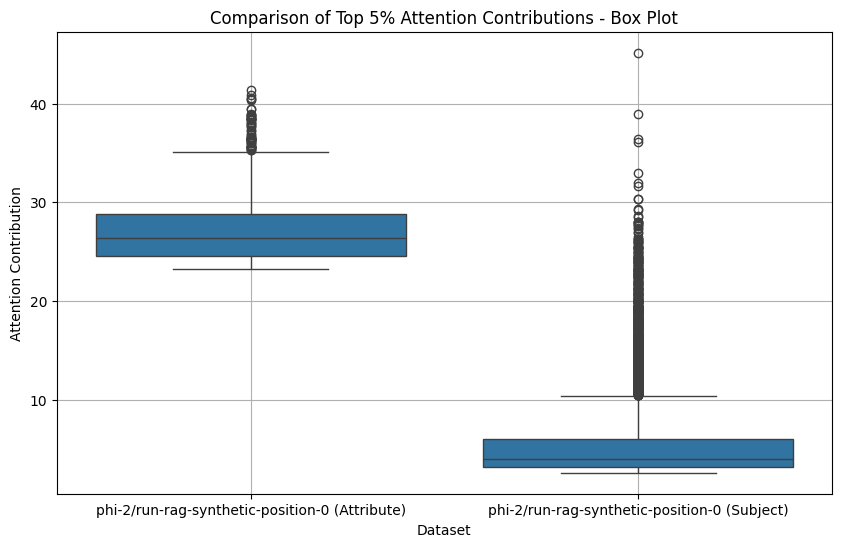

In [19]:
#This compares attribute and Subject across the phi-2 rag position 0.
compare_top_values_histograms(['phi-2/run-rag-synthetic-position-0'], percentile=95, contribution="both")

864
Exception encountered: list index out of range
Error occurred for data id: 824
863


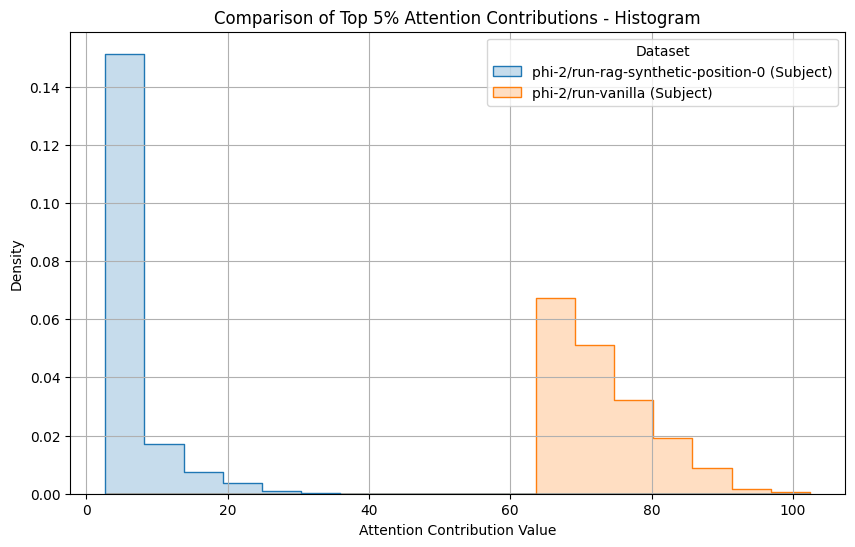

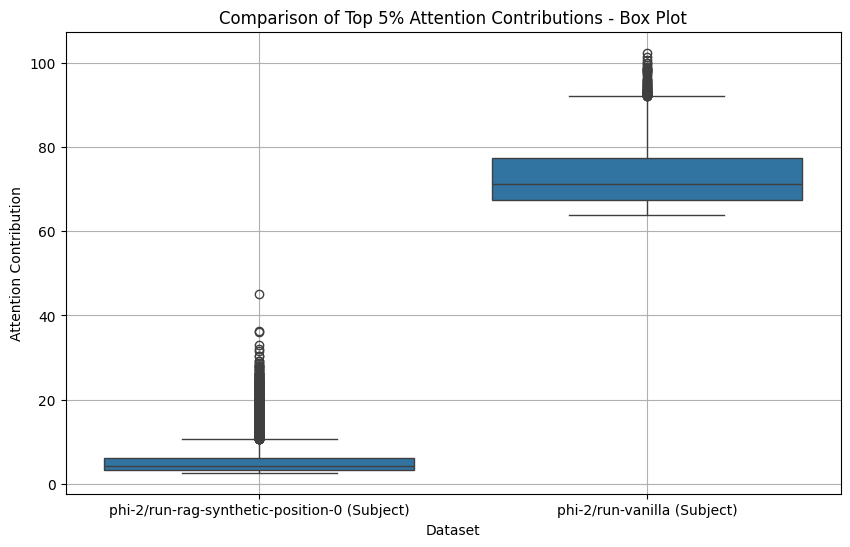

In [21]:
#This compares subject contribution for correct predictions for top 5% across rag with position 0 and non rag which is vanilla. To compare for incorrect change 0 to 2. 1 for semi correct.
compare_top_values_histograms([f"phi-2/run-rag-synthetic-position-0", "phi-2/run-vanilla"], 95,contribution="subject", indexes = getPredictionCategories("phi-2/run-rag-synthetic-position-0")[0])

# Contribution aggregated across Layers

In [25]:
def aggregate_layer_contributions(directory, indexes=None, contribution = "subject"):
    if 'vanilla' in directory and contribution == "attribute":
        raise ValueError("Attribute contribution is not available for Non Rag.")
    def get_query_index(token_labels, constraint):
        try:
            return find_all_phrase_indexes(token_labels, constraint.strip())[-1]
        except IndexError:
            return find_all_phrase_indexes(token_labels, constraint)[-1]

    file_names = os.listdir(os.path.join(directory, 'data'))
    aggregated_contributions = None
    count = 0

    for name in file_names:
        with open(os.path.join(directory, 'data', name), 'rb') as f:
            data = plk.load(f)
        if indexes:
            if int(data['id']) not in indexes:
                continue
        try:
            # Attempt to get the query subject index
            if contribution == "subject":
                query_subject_index = get_query_index(data['token_labels'], data['constraints'][-1])
            elif contribution == "attribute":
                query_subject_index = get_query_index(data['token_labels'], data['constraints'][0])
            else:
                raise Exception("Invalid contribution type")

            
            # Calculate flow_info using the obtained index
            flow_info = data['all_token_contrib_norms'].T[query_subject_index[0]:query_subject_index[1] + 1]
            
            # Sum contributions across tokens to get a 1D array of contributions per layer
            layer_contributions = np.sum(flow_info, axis=0)
            
            if aggregated_contributions is None:
                aggregated_contributions = layer_contributions
            else:
                aggregated_contributions += layer_contributions
            
            count += 1
        except Exception as e:
            print(f"Exception encountered: {e}")
            print("Error occurred for data id:", data["id"])
    
    if count > 0:
        aggregated_contributions /= count
    
    return aggregated_contributions

In [6]:
def plot_histogram(data, title='Layer Contributions Histogram', xlabel='Layers', ylabel='Contribution'):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(data)), data, alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', alpha=0.75)
    plt.show()


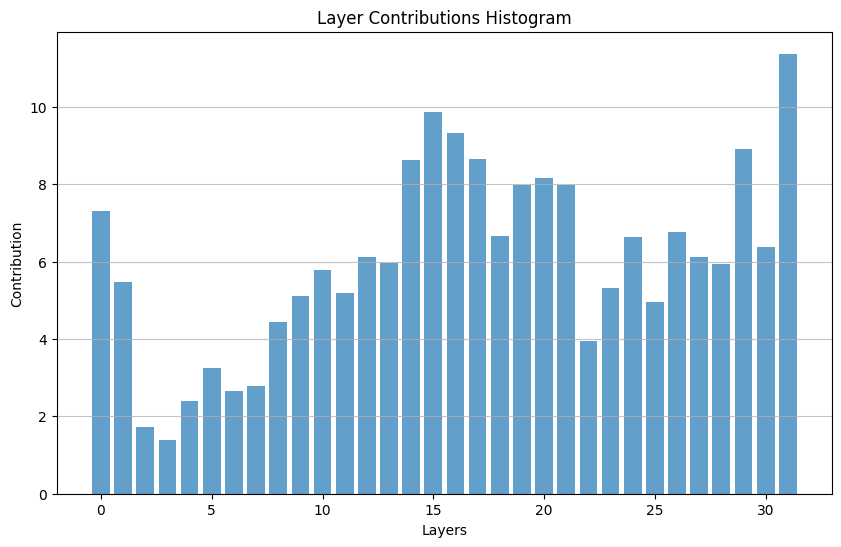

In [24]:
# Gets attention contribution for subject token across layers. index whould be 0 for correct, 2 for incorrect.
directory = 'run-vanilla'
aggregated_contributions = aggregate_layer_contributions(directory, indexes = getPredictionCategories(directory)[2], contribution = "subject")
plot_histogram(aggregated_contributions)